In [44]:
""" 가중치가 구현된 다수결 투표 """
import numpy as np

test1 = np.argmax(np.bincount([0, 0, 1], weights = [0.2, 0.2, 0.6]))
print(test1)

ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
# average로 weights를 적용한 가중 평균 구함
print(p)
print(np.argmax(p))

1
[0.58 0.42]
0


In [59]:
""" 다수결 투표 앙상블 분류기 구현 """
from sklearn.base import BaseEstimator
# 그리드 탐색, 파이프라인에 필요한 get_params, set_params 상속
from sklearn.base import ClassifierMixin
# score 메소드를 통해 정확도 계산을 얻기 위해
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
# 파이썬 2.6 버전에서 사용하기 위해
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin) :
    """
    다수결 투표 앙상블 분류기 
    
    매개변수
    --------
    classifiers : 배열 타입, 크기 = [n_classifiers]
     ㄴ 앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
     ㄴ 기본값 : 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 된다.
        'probability'면 확률 합이 가장 큰 인덱스로 클래스 레이블을 예측한다. (보정된 분류기에 보편적으로 사용)
        
    weigts : 배열 타입, 크기 = [n_classifiers]
     ㄴ 선택 사항, 기본값 : None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치를 적용한다.
        'weigths = None'이면 동일하게 취급한다.
    """
    
    def __init__(self, classifiers, vote = 'classlabel', weights = None) : 
        self.classifiers = classifiers
        self.named_classifiers = {key : value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y) :
        # self.predict 메소드에서 np.argmax를 호출 할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용한다.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers : 
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
            
        return self

    def predict(self, X) : 
        if self.vote == 'probability' :
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
        else : # 'classlabel'
            # clf.predict를 통해 결과를 모은다.
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x : np.argmax(np.bincount(x, weights = self.weights)),
                                          axis = 1, arr = predictions)
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            
        return maj_vote
    
    def predict_proba(self, X) :
        """
        X에 대한 클래스 확률 예측
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights = self.weights)
        
        return avg_proba

    def get_params(self, deep = True) :
        """
        GirdSearch를 위해 분류기의 매개변수 이름을 반환
        """
        if not deep : 
            return super(MajorityVoteClassifier, self).get_params(deep = False)
        else : 
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers) : 
                for key, value in six.iteritems(step.get_params(deep = True)) : 
                    out['%s__%s' % (name, key)] = value
            return out

In [60]:
""" 붓꽃 데이터 가져오기 """
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5,
                                                   random_state = 1, stratify = y)

In [61]:
""" 10-겹 교차 검증으로 성능 평가 """
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(solver = 'liblinear',
                         penalty = 'l2', C = 0.001, random_state = 1)
clf2 = DecisionTreeClassifier(max_depth = 1,
                             criterion = 'entropy', random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1,
                           p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-겹 교차 검증 : \n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels) :
    scores = cross_val_score(estimator = clf,
                            X = X_train, y = y_train,
                            cv = 10, scoring = 'roc_auc')
    print('ROC AUC : %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-겹 교차 검증 : 

ROC AUC : 0.92 (+/- 0.15) [Logistic regression]
ROC AUC : 0.87 (+/- 0.18) [Decision tree]
ROC AUC : 0.85 (+/- 0.13) [KNN]


In [62]:
""" 각 분류기 다수결 투표에 연결하기 """

mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels) :
    scores = cross_val_score(estimator = clf,
                            X = X_train, y = y_train,
                            cv = 10, scoring = 'roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))
    

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


Text(0, 0.5, 'True positive rate (TPR)')

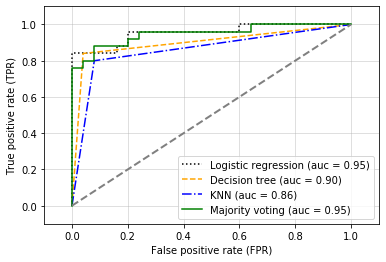

In [63]:
""" 앙상블 분류기의 평가와 튜닝 """
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles) :
    # 양성 클래스의 레이블이 1이라고 가정한다.
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr, tpr, color = clr,
            linestyle = ls,
            label = '%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--',
        color = 'gray', linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

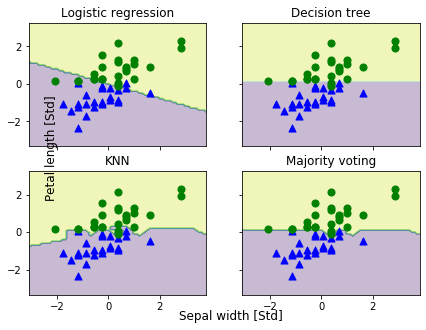

In [64]:
""" 앙상블 분류기의 결정 경계 비교 """
from itertools import product

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 2, ncols = 2,
                       sharex = 'col', sharey = 'row',
                       figsize = (7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels) : 
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                 X_train_std[y_train == 0, 1],
                                 c = 'blue', marker = '^', s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                 X_train_std[y_train == 1, 1],
                                 c = 'green', marker = 'o', s = 50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5,
        s = 'Sepal width [Std]', ha = 'center', va = 'center', fontsize = 12)
plt.text(-10.5, 4.5,
        s = 'Petal length [Std]', ha = 'center', va = 'center', fontsize = 12, rotation = 90)
plt.show()

In [71]:
""" GridSearchCV 매개변수에 접근해보기 """
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='liblinear', tol=0.0001, verbose=0,
                                     warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_s

In [75]:
""" 그리드 서치로 개별 분류기 속성에 접근하기 """
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth' : [1, 2],
         'pipeline-1__clf__C' : [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator = mv_clf, param_grid = params,
                   cv = 10, scoring = 'roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))
    
print('최적의 매개변수 : %s' % grid.best_params_)
print('정확도 : %.2f' % grid.best_score_)
print('트리 깊이는 영향이 없는 것으로 판단된다.')

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
최적의 매개변수 : {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도 : 0.98
트리 깊이는 영향이 없는 것으로 판단된다.
